In [ ]:
!pip install missingno


from google.colab import files
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import LabelEncoder

In [ ]:
uploaded = files.upload()

Saving OSA_extreme_male.xlsx to OSA_extreme_male (1).xlsx
Saving OSA_PCA_extreme_male.xlsx to OSA_PCA_extreme_male (1).xlsx


In [ ]:
# Specify the file name
file_name1 = 'OSA_extreme_male.xlsx'
file_name2 = 'OSA_PCA_extreme_male.xlsx'

# Read the Excel file into a DataFrame
df_tmp_class = pd.read_excel(file_name1)
df_tmp_class.head(5)

,IAH,Weight,Height,Age,PerCervical,Gender,BMI,OSA
0,9.0,80,173,32,40,hombre,26.729927,Healthy
1,2.0,109,190,32,42,hombre,30.193906,Healthy
2,34.0,86,169,39,42,hombre,30.110991,Severe
3,60.0,145,172,47,44,hombre,49.012980,Severe
4,3.7,90,180,36,40,hombre,27.777778,Healthy


In [ ]:
# Read the Excel file into a DataFrame
pca_df = pd.read_excel(file_name2)
pca_df.head(5)

,Z1,Z2,Z3,OSA
0,-1.163697,-0.779219,-0.912312,Healthy
1,0.897835,-2.227615,0.362919,Healthy
2,-0.413965,0.155920,-1.018871,Severe
3,3.821940,0.745807,-1.664972,Severe
4,-0.545290,-1.187623,-0.196925,Healthy


### Feature normalization

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_tmp_class[['PerCervical', 'BMI', 'Age', 'Height', 'Weight']])

df_tmp_class['BMI'] = scaled_features[:, 1]
df_tmp_class['PerCervical'] = scaled_features[:, 0]
df_tmp_class['Age'] = scaled_features[:, 2]
df_tmp_class['Height'] = scaled_features[:, 3]
df_tmp_class['Weight'] = scaled_features[:, 4]

In [ ]:
scaled_features = scaler.fit_transform(pca_df[['Z1', 'Z2', 'Z3']])

pca_df['Z1'] = scaled_features[:, 0]
pca_df['Z2'] = scaled_features[:, 1]
pca_df['Z3'] = scaled_features[:, 2]

# Training

##### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
features_class = ['PerCervical', 'BMI', 'Age']

# convert it into numerical matrix
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(df_tmp_class['OSA'])

## Example: Train 80% and Test 20%
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# enumerate splits
outer_results = list()
best_model_rnd_frst_class = None
accuracy = []
precision = []
recall = []
f1 = []
roc = []
best_params_list = {}
best_params_list['n_estimators'] = []
best_params_list['max_features'] = []

for train_ix, test_ix in cv_outer.split(X_c):
    # split data
    X_train, X_test = X_c[train_ix, :], X_c[test_ix, :]
    y_train, y_test = y_c[train_ix], y_c[test_ix]

    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

    # define the model
    model_random_forest = RandomForestClassifier(random_state=1)

    # define search space
    space = dict()
    space['n_estimators'] = [100, 250, 500, 600]
    space['max_features'] = [2, 3, 4]

    # define search
    search = GridSearchCV(model_random_forest, space, scoring='accuracy', cv=cv_inner, refit=True)

    # execute search
    result = search.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model_rnd_frst_class = result.best_estimator_

    # Print only the parameters that were searched with GridSearchCV
    print("Best Model Parameters:")
    for param_name, param_value in result.best_params_.items():
        print(f"{param_name}: {param_value}")

        # Add the parameter to the list
        best_params_list[param_name].append(param_value)

    yhat = best_model_rnd_frst_class.predict(X_test)

    # evaluate the model
    accuracy.append(accuracy_score(y_test, yhat))
    precision.append(precision_score(y_test, yhat, pos_label='Severe'))
    recall.append(recall_score(y_test, yhat, pos_label='Severe'))
    f1.append(f1_score(y_test, yhat, pos_label='Severe'))

# summarize the estimated performance of the model
print()
print('Performance in Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('Performance in precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))
print('Performance in recall: %.3f (%.3f)' % (np.mean(recall), np.std(recall)))
print('Performance in f1 score: %.3f (%.3f)' % (np.mean(f1), np.std(f1)))
print()

for k in best_params_list.keys():
    # Count the occurrences of each parameter value
    param_counter = Counter(best_params_list[k])

    # Check if the parameters are floats
    if not all(isinstance(value, str) for value in best_params_list[k]):
        # If they are numerical, print mean and standard deviation
        param_values = [float(value) for value in best_params_list[k]]
        print(f"Parameter: {k}, Mean: {np.mean(param_values):.4f}, Std: {np.std(param_values):.4f}")
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")
    else:
        # If they are strings, print the most frequent values
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")

Best Model Parameters:
max_features: 2
n_estimators: 100
Best Model Parameters:
max_features: 3
n_estimators: 250
Best Model Parameters:
max_features: 3
n_estimators: 100
Best Model Parameters:
max_features: 3
n_estimators: 250
Best Model Parameters:
max_features: 2
n_estimators: 500
Best Model Parameters:
max_features: 2
n_estimators: 500
Best Model Parameters:
max_features: 3
n_estimators: 250
Best Model Parameters:
max_features: 2
n_estimators: 600
Best Model Parameters:
max_features: 2
n_estimators: 100
Best Model Parameters:
max_features: 2
n_estimators: 500

Performance in Accuracy: 0.729 (0.069)
Performance in precision: 0.706 (0.080)
Performance in recall: 0.740 (0.135)
Performance in f1 score: 0.716 (0.087)

Parameter: n_estimators, Mean: 315.0000, Std: 183.0983
Parameter: n_estimators, Most frequent values: [(100, 3)]
Parameter: max_features, Mean: 2.4000, Std: 0.4899
Parameter: max_features, Most frequent values: [(2, 6)]


##### Logistique regression

In [ ]:
from sklearn.linear_model import LogisticRegression

features_class = ['PerCervical', 'BMI', 'Age']

# convert it into numerical matrix
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(df_tmp_class['OSA'])

# Printing
print('X shape:', X_c.shape, 'y shape: ', y_c.shape)

## Example: Train 80% and Test 20%
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size = 0.2, random_state = 42)

cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# lists and dictionnaries
outer_results = list()
best_model_log_regress = None
best_params_list = {}
best_params_list['C'] = []
accuracy = []
precision = []
recall = []
f1 = []

# configure the cross-validation procedure
for train_ix, test_ix in cv_outer.split(X_c):
    # split data
    X_train, X_test = X_c[train_ix, :], X_c[test_ix, :]
    y_train, y_test = y_c[train_ix], y_c[test_ix]

    # configure the cross-validation procedure
    cv_inner = KFold(n_splits = 3, shuffle = True, random_state = 1)

    # define the model (Logistic Regression)
    model_logistic_regression = LogisticRegression(random_state = 1, max_iter = 1000)

    # define search space
    space = dict()
    space['C'] = [0.001, 0.01, 0.1, 1, 10]

    # define search
    search = GridSearchCV(model_logistic_regression, space, scoring = 'accuracy', cv = cv_inner, refit = True)

    # execute search
    result = search.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model_log_regress = result.best_estimator_

    # Print only the parameters that were searched with GridSearchCV
    print("Best Model Parameters:")
    for param_name, param_value in result.best_params_.items():
        print(f"{param_name}: {param_value}")

        # Add the parameter to the list
        best_params_list[param_name].append(param_value)

    # evaluate the model
    yhat = best_model_log_regress.predict(X_test)
    accuracy.append(accuracy_score(y_test, yhat))
    precision.append(precision_score(y_test, yhat, pos_label='Severe'))
    recall.append(recall_score(y_test, yhat, pos_label='Severe'))
    f1.append(f1_score(y_test, yhat, pos_label='Severe'))

# summarize the estimated performance of the model
print()
print('Performance in Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('Performance in precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))
print('Performance in recall: %.3f (%.3f)' % (np.mean(recall), np.std(recall)))
print('Performance in f1 score: %.3f (%.3f)' % (np.mean(f1), np.std(f1)))
print()

for k in best_params_list.keys():
    # Count the occurrences of each parameter value
    param_counter = Counter(best_params_list[k])

    # Check if the parameters are floats
    if not all(isinstance(value, str) for value in best_params_list[k]):
        # If they are numerical, print mean and standard deviation
        param_values = [float(value) for value in best_params_list[k]]
        print(f"Parameter: {k}, Mean: {np.mean(param_values):.4f}, Std: {np.std(param_values):.4f}")
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")
    else:
        # If they are strings, print the most frequent values
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")

X shape: (262, 3) y shape:  (262,)
Best Model Parameters:
C: 0.1
Best Model Parameters:
C: 10
Best Model Parameters:
C: 0.1
Best Model Parameters:
C: 10
Best Model Parameters:
C: 1
Best Model Parameters:
C: 10
Best Model Parameters:
C: 0.01
Best Model Parameters:
C: 0.1
Best Model Parameters:
C: 1
Best Model Parameters:
C: 1

Performance in Accuracy: 0.710 (0.063)
Performance in precision: 0.713 (0.122)
Performance in recall: 0.649 (0.144)
Performance in f1 score: 0.666 (0.116)

Parameter: C, Mean: 3.3310, Std: 4.3826
Parameter: C, Most frequent values: [(0.1, 3)]


##### Super Vector Machine Model

In [ ]:
from sklearn.svm import SVC
features_class = ['PerCervical', 'BMI', 'Age']

# Convert features and target into numerical arrays
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(df_tmp_class['OSA'])

# Train and Test Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size = 0.2, random_state = 42)

# lists and dictionnaries
cv_outer = KFold(n_splits = 10, shuffle = True, random_state = 1)
outer_results = []
best_model_svm = None
best_params_list = {}
best_params_list['C'] = []
best_params_list['gamma'] = []
best_params_list['kernel'] = []
accuracy = []
precision = []
recall = []
f1 = []

# Configure the cross-validation procedure
for train_ix, test_ix in cv_outer.split(X_c):
    # Split the data
    X_train, X_test = X_c[train_ix], X_c[test_ix]
    y_train, y_test = y_c[train_ix], y_c[test_ix]

    # Configure the cross-validation procedure
    cv_inner = KFold(n_splits = 3, shuffle = True, random_state = 1)

    # Define the SVM model with RBF kernel
    model_svm = SVC(kernel = "linear", C = 1, gamma = "scale", probability  = True)

    space = {"C": [0.001, 0.01, 0.1, 1, 10],
             "gamma": ["scale", "auto"],
             "kernel": ["rbf", "linear", "poly"]}

    # Define the search
    search = GridSearchCV(model_svm, space, scoring = "accuracy", cv = cv_inner, refit = True)

    # Execute the search
    result = search.fit(X_train, y_train)

    # Get the best performing model fit on the whole training set
    best_model_svm = result.best_estimator_

    # Print the parameters of the best model
    print("Best Model Parameters:")
    for param_name, param_value in result.best_params_.items():
        print(f"{param_name}: {param_value}")

        # Add the parameter to the list
        best_params_list[param_name].append(param_value)

    # Evaluate the model on the holdout dataset
    yhat = best_model_svm.predict(X_test)

    accuracy.append(accuracy_score(y_test, yhat))
    precision.append(precision_score(y_test, yhat, pos_label='Severe'))
    recall.append(recall_score(y_test, yhat, pos_label='Severe'))
    f1.append(f1_score(y_test, yhat, pos_label='Severe'))

# summarize the estimated performance of the model
print('Performance in Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('Performance in precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))
print('Performance in recall: %.3f (%.3f)' % (np.mean(recall), np.std(recall)))
print('Performance in f1 score: %.3f (%.3f)' % (np.mean(f1), np.std(f1)))
print()

from collections import Counter

for k in best_params_list.keys():
    # Count the occurrences of each parameter value
    param_counter = Counter(best_params_list[k])

    # Check if the parameters are floats
    if not all(isinstance(value, str) for value in best_params_list[k]):
        # If they are numerical, print mean and standard deviation
        param_values = [float(value) for value in best_params_list[k]]
        print(f"Parameter: {k}, Mean: {np.mean(param_values):.4f}, Std: {np.std(param_values):.4f}")
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")
    else:
        # If they are strings, print the most frequent values
        most_frequent_values = param_counter.most_common(1)
        print(f"Parameter: {k}, Most frequent values: {most_frequent_values}")

Best Model Parameters:
C: 0.1
gamma: auto
kernel: rbf
Best Model Parameters:
C: 1
gamma: scale
kernel: linear
Best Model Parameters:
C: 10
gamma: scale
kernel: rbf
Best Model Parameters:
C: 10
gamma: scale
kernel: rbf
Best Model Parameters:
C: 0.1
gamma: scale
kernel: linear
Best Model Parameters:
C: 10
gamma: scale
kernel: rbf
Best Model Parameters:
C: 0.01
gamma: scale
kernel: linear
Best Model Parameters:
C: 1
gamma: scale
kernel: rbf
Best Model Parameters:
C: 1
gamma: scale
kernel: rbf
Best Model Parameters:
C: 1
gamma: scale
kernel: rbf
Performance in Accuracy: 0.722 (0.066)
Performance in precision: 0.710 (0.113)
Performance in recall: 0.704 (0.174)
Performance in f1 score: 0.690 (0.119)

Parameter: C, Mean: 3.4210, Std: 4.3242
Parameter: C, Most frequent values: [(1, 4)]
Parameter: gamma, Most frequent values: [('scale', 9)]
Parameter: kernel, Most frequent values: [('rbf', 7)]


##### K_MEANS

In [ ]:
from sklearn.cluster import KMeans

features_class = ['PerCervical', 'BMI', 'Age']

# Convert features and target into numerical arrays
X = df_tmp_class[features_class]
y = df_tmp_class['OSA']

# Train and Test Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train K-means model to get cluster assignments;f79
kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 1)
cluster_labels = kmeans.fit_predict(X_train_c)

# Create a DataFrame with actual labels and predicted clusters
df = pd.DataFrame({'Actual_Labels': y_train_c, 'Predicted_Clusters': cluster_labels})

# Create a contingency table
contingency_table = pd.crosstab(df['Actual_Labels'], df['Predicted_Clusters'], normalize='index')

# Display the contingency table
print(contingency_table)

# Assuming 'contingency_table' is the result from pd.crosstab
class_labels = contingency_table.index
cluster_labels = contingency_table.columns

# Specify the threshold
threshold = 0.7

# Iterate through all classes and clusters
for class_label in class_labels:
    for cluster_label in cluster_labels:
        # Check if the proportion is greater than the threshold
        proportion = contingency_table.loc[class_label, cluster_label]
        if proportion > threshold:
            print(f"The class '{class_label}' is represented by more than {threshold * 100}% in cluster '{cluster_label}'.")
        else:
            print(f"The class '{class_label}' is not represented by more than {threshold * 100}% in cluster '{cluster_label}'.")

Predicted_Clusters         0         1         2        3
Actual_Labels                                            
Healthy             0.211009  0.284404  0.036697  0.46789
Severe              0.310000  0.370000  0.240000  0.08000
The class 'Healthy' is not represented by more than 70.0% in cluster '0'.
The class 'Healthy' is not represented by more than 70.0% in cluster '1'.
The class 'Healthy' is not represented by more than 70.0% in cluster '2'.
The class 'Healthy' is not represented by more than 70.0% in cluster '3'.
The class 'Severe' is not represented by more than 70.0% in cluster '0'.
The class 'Severe' is not represented by more than 70.0% in cluster '1'.
The class 'Severe' is not represented by more than 70.0% in cluster '2'.
The class 'Severe' is not represented by more than 70.0% in cluster '3'.


In [ ]:
from sklearn.cluster import KMeans

class CustomModel:
    def __init__(self, n_clusters=2, imbalance_ratio=2):
        self.n_clusters = n_clusters
        self.imbalance_ratio = imbalance_ratio
        self.kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state = 1)
        self.svms = []
        self.cluster_labels = []
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        # Encode string labels to integers
        y = self.label_encoder.fit_transform(y)

        # Train KMeans
        self.kmeans.fit(X)
        self.cluster_labels = self.kmeans.labels_

        # For each cluster
        for i in range(self.n_clusters):
            X_cluster = X[self.cluster_labels == i]
            y_cluster = y[self.cluster_labels == i]

            # Check if the cluster is imbalanced
            counter = Counter(y_cluster)
            majority_class = counter.most_common(1)[0]
            if float(majority_class[1] / len(y_cluster)) > float(self.imbalance_ratio)*0.1:

                # If imbalanced, assign all data points to the majority class
                self.svms.append(int(majority_class[0]))
            else:
                # If not, train an SVM on the cluster
                mode = SVC()
                mode.fit(X_cluster, y_cluster)
                self.svms.append(mode)

    def predict(self, X):
      # Predict the cluster for each data point
      cluster_predictions = self.kmeans.predict(X)
      y_pred = np.empty(len(X), dtype=int)

      # For each cluster
      for i in range(self.n_clusters):
          # If the SVM is an integer, it means the cluster was imbalanced and all data points are assigned to the majority class
          if type(self.svms[i]) == int:
              y_pred[cluster_predictions == i] = self.svms[i]
          else:
              # If not, use the SVM to predict the class
              y_pred[cluster_predictions == i] = self.svms[i].predict(X[cluster_predictions == i])

      # Decode integer predictions back to original string labels
      y_pred = self.label_encoder.inverse_transform(y_pred)

      return y_pred

In [ ]:
from sklearn.model_selection import StratifiedKFold

features_class = ['Z1', 'Z2', 'Z3']
X = pca_df[features_class]
y = pca_df['OSA']
X_c = np.array(pca_df[features_class])
y_c = np.array(pca_df['OSA'])

# Define the number of folds for cross-validation
n_splits = 5

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize CustomModel
customModel = CustomModel(n_clusters=2, imbalance_ratio=8)

# Initialize metrics lists
accuracy, precision, recall, f1 = [], [], [], []

# Perform cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train_c, X_test_c = X_c[train_index], X_c[test_index]
    y_train_c, y_test_c = y_c[train_index], y_c[test_index]

    customModel.fit(X_train_c, y_train_c)
    y_pred = customModel.predict(X_test_c)

    accuracy.append(accuracy_score(y_test_c, y_pred))
    precision.append(precision_score(y_test_c, y_pred, pos_label='Severe'))
    recall.append(recall_score(y_test_c, y_pred, pos_label='Severe'))
    f1.append(f1_score(y_test_c, y_pred, pos_label='Severe'))

print('Performance in Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('Performance in precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))
print('Performance in recall: %.3f (%.3f)' % (np.mean(recall), np.std(recall)))
print('Performance in f1 score: %.3f (%.3f)' % (np.mean(f1), np.std(f1)))

Performance in Accuracy: 0.691 (0.116)
Performance in precision: 0.683 (0.137)
Performance in recall: 0.793 (0.055)
Performance in f1 score: 0.721 (0.060)


# Evaluation

#### Random Forest Classifier:

Random Forest Classifier Metrics with Cross-Validation:
Accuracy: 0.74
Precision: 0.75
Recall: 0.69
F1 Score: 0.72
AUC-ROC: 0.81


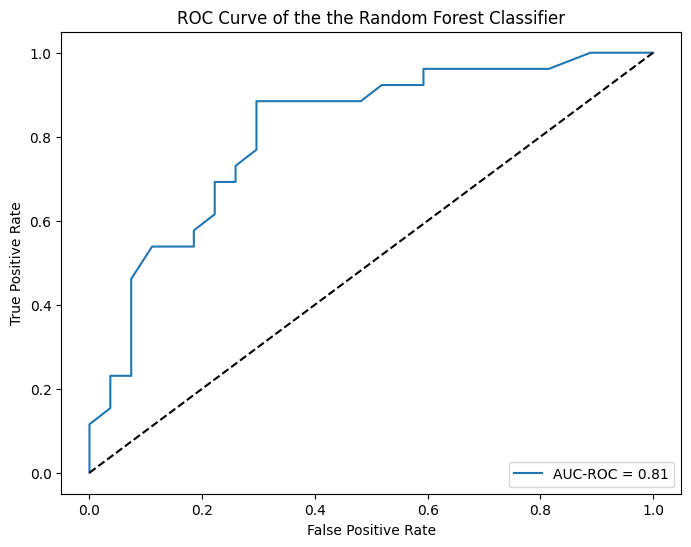

In [ ]:
features_class = ['PerCervical', 'BMI', 'Age']

# Convert labels to binary format
label_encoder = LabelEncoder()
y_c_encoded = label_encoder.fit_transform(df_tmp_class['OSA'])

# Convert it into a numerical matrix
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(y_c_encoded)

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Train your model before using it for prediction.
best_model_rnd_frst_class = RandomForestClassifier(n_estimators=100, max_features=2, random_state=1)
best_model_rnd_frst_class.fit(X_train_c, y_train_c)

y_pred = best_model_rnd_frst_class.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)
roc_auc = roc_auc_score(y_test_c, best_model_rnd_frst_class.predict_proba(X_test_c)[:, 1])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_c, best_model_rnd_frst_class.predict_proba(X_test_c)[:, 1])

print("Random Forest Classifier Metrics with Cross-Validation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the the Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

#### Logistic Regression:

Logistic Regression Metrics with Cross-Validation:
Accuracy: 0.75
Precision: 0.74
Recall: 0.77
F1 Score: 0.75
AUC-ROC: 0.82


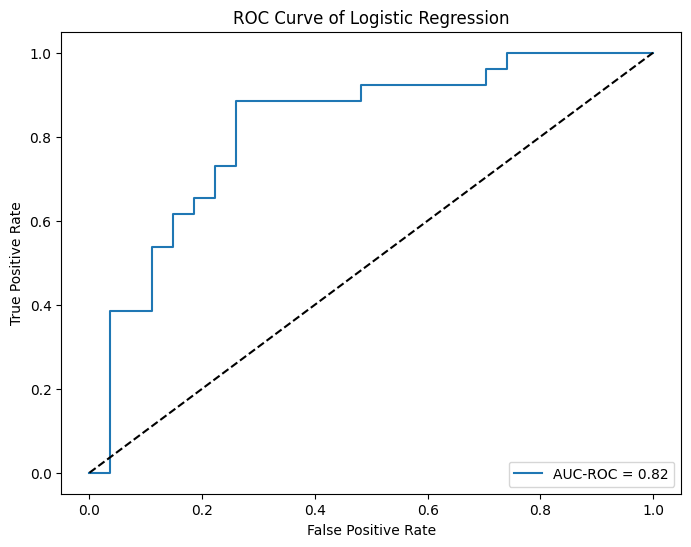

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Convert labels to binary format
label_encoder = LabelEncoder()
y_c_encoded = label_encoder.fit_transform(df_tmp_class['OSA'])

features_class = ['PerCervical', 'BMI', 'Age']

# Convert it into a numerical matrix
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(y_c_encoded)

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

best_model_log_regress = LogisticRegression(C=0.1, random_state=1, max_iter=1000)
best_model_log_regress.fit(X_train_c, y_train_c)

y_pred = best_model_log_regress.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)
roc_auc = roc_auc_score(y_test_c, best_model_log_regress.predict_proba(X_test_c)[:, 1])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_c, best_model_log_regress.predict_proba(X_test_c)[:, 1])

print("Logistic Regression Metrics with Cross-Validation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc='lower right')
plt.show()

#### Support Vector Machine (SVM):

SVM Metrics with Cross-Validation:
Accuracy: 0.77
Precision: 0.75
Recall: 0.81
F1 Score: 0.78
AUC-ROC: 0.85


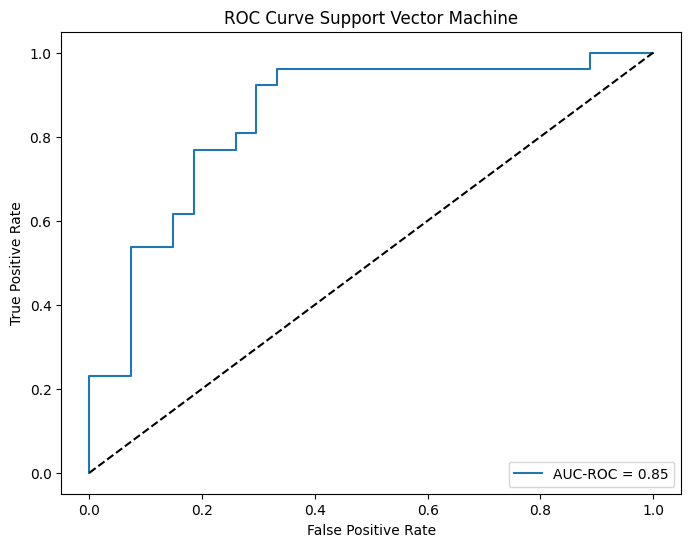

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

features_class = ['PerCervical', 'BMI', 'Age']

# Convert it into a numerical matrix
X_c = np.array(df_tmp_class[features_class])
y_c = np.array(df_tmp_class['OSA'])

# Encode labels to 0 and 1
label_encoder = LabelEncoder()
y_c_encoded = label_encoder.fit_transform(y_c)

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c_encoded, test_size=0.2, random_state=42)

best_model_svm = SVC(kernel="rbf", C=1, gamma="scale", probability=True)
best_model_svm.fit(X_train_c, y_train_c)

y_pred = best_model_svm.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)
roc_auc = roc_auc_score(y_test_c, best_model_svm.predict_proba(X_test_c)[:, 1])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_c, best_model_svm.predict_proba(X_test_c)[:, 1])

print("SVM Metrics with Cross-Validation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Support Vector Machine')
plt.legend(loc='lower right')
plt.show()

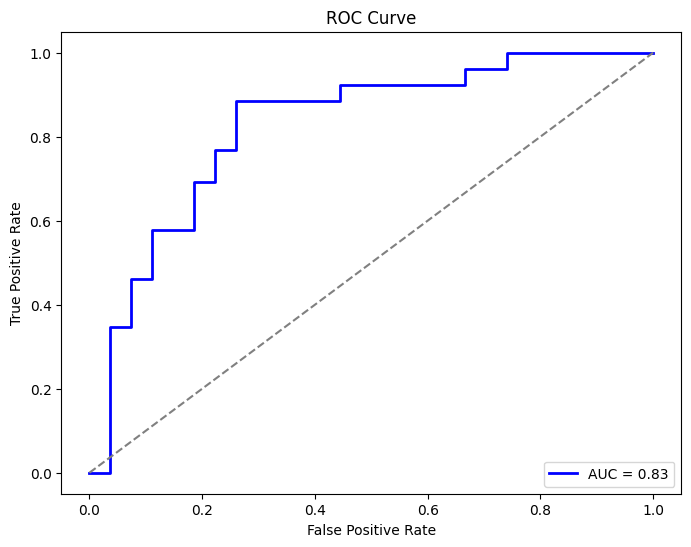

SVM Metrics with Cross-Validation:
Accuracy: 0.75
Precision: 0.74
Recall: 0.77
F1 Score: 0.75
AUC-ROC: 0.83


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

features_class = ['Z1', 'Z2', 'Z3']

# Convert features and target into numerical arrays
X_c = np.array(pca_df[features_class])

# Encode the target variable
label_encoder = LabelEncoder()
y_c = label_encoder.fit_transform(pca_df['OSA'])

# Train and Test Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

best_model_svm_pca = SVC(kernel="linear", C=1, gamma="scale", probability=True)
best_model_svm_pca.fit(X_train_c, y_train_c)

y_pred = best_model_svm_pca.predict(X_test_c)
accuracy = accuracy_score(y_test_c, y_pred)
precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)

# Calculate ROC Curve and AUC-ROC
y_pred_prob = best_model_svm_pca.predict_proba(X_test_c)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_prob)
auc = roc_auc_score(y_test_c, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("SVM Metrics with Cross-Validation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")

#### KM-SVM

CustomModel Metrics with Cross-Validation:
Accuracy: 0.77
Precision: 0.79
Recall: 0.73
F1 Score: 0.76
AUC-ROC: 0.77


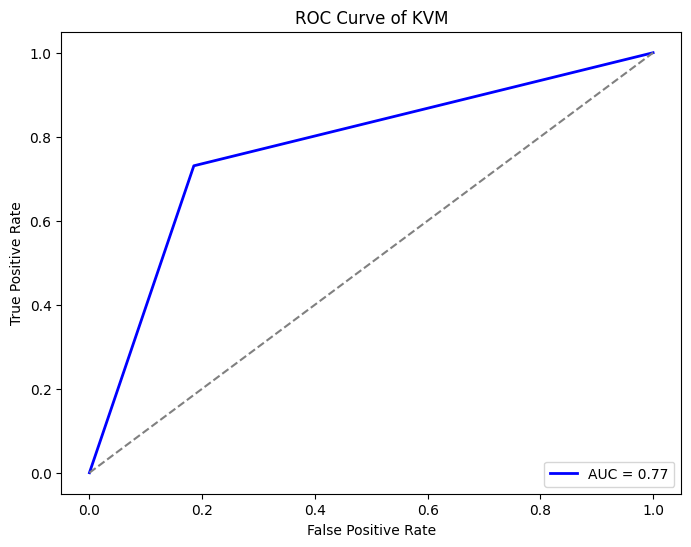

In [ ]:
features_class = ['Z1', 'Z2', 'Z3']
X_c = np.array(pca_df[features_class])
y_c = np.array(pca_df['OSA'])

# Encode the target variable
label_encoder = LabelEncoder()
y_c = label_encoder.fit_transform(pca_df['OSA'])

# Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

customModel = CustomModel(n_clusters = 2, imbalance_ratio = 8)
customModel.fit(X_train_c, y_train_c)

y_pred = customModel.predict(X_test_c)

accuracy = accuracy_score(y_test_c, y_pred)
precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)


# Calculate ROC Curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred)
auc = roc_auc_score(y_test_c, y_pred)

print("CustomModel Metrics with Cross-Validation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of KVM')
plt.legend(loc='lower right')
plt.show()